In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import ipywidgets as w
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
plt.rcParams.update({'font.size': 16})
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from typhon.retrieval.qrnn import set_backend, QRNN
set_backend("pytorch")
import statistics

## INPUT PARAMETERS 

In [2]:
depth     = 4
width     = 128
quantiles = np.array([0.002, 0.03, 0.16, 0.5, 0.84, 0.97, 0.998])
batchSize = 128

target = 'I1V'


inChannels = np.array(['I1V', 'I2V', 'I3V', 'I5V' , 'I6V', 'I7V', 'I8V', 'I9V', 'I10V', 'I11V'])
#inChannels = np.array(['I1V', 'I2V', 'I3V', 'MWI-15', 'MWI-16', 'I5V', 'I6V', 'I7V', 'I8V', 'I9V', 'I10V', 'I11V', 'I11H'])
#inChannels = np.array([target, 'I5V' , 'I6V', 'I7V', 'I8V', 'I9V', 'I10V', 'I11V'])
i183, = np.argwhere(inChannels == target)[0]

## Read TEST data

In [3]:
from ici import iciData

data = iciData("TB_ICI_test.nc", 
               inChannels, target, 
               batch_size = batchSize)  

x_noise = data.add_noise(data.x, data.index)


## Load the QRNN model for target

In [4]:
file = 'qrnn_ici_%s_%s_%s.nc'%(depth, width, target)
print (file)
qrnn = QRNN.load(file)

qrnn_ici_4_128_I1V.nc


#### predict the expectation value

In [5]:
y_pre, y_prior, y0, y, y_pos_mean = statistics.predict(data, qrnn)


binstep = 0.5
bins = np.arange(-20, 15, binstep)
iq = np.argwhere(quantiles == 0.5)[0,0]

[0, 1, 2, 5, 6, 7, 8, 9, 10, 11]


In [6]:
hist_noise  = statistics.calculate_pdf(y, y0, bins)

hist_pre    = statistics.calculate_pdf(y_pre[:, iq], y0, bins)

hist_prior  = statistics.calculate_pdf(y_prior[:, i183], y0, bins)

hist_pos_mean    = statistics.calculate_pdf(y_pre[:, iq], y0, bins)

im = np.abs(y_pos_mean - y_prior[:, i183]) <= 5.0
hist_pos_mean_5  = statistics.calculate_pdf(y_pre[:, iq], y0, bins, im)

im = np.abs(y_pos_mean - y_prior[:, i183]) <= 10.0
hist_pos_mean_10 = statistics.calculate_pdf(y_pre[:, iq], y0, bins, im)

im = np.abs(y_pos_mean - y_prior[:, i183]) <= 15.0
hist_pos_mean_15 = statistics.calculate_pdf(y_pre[:, iq], y0, bins, im)




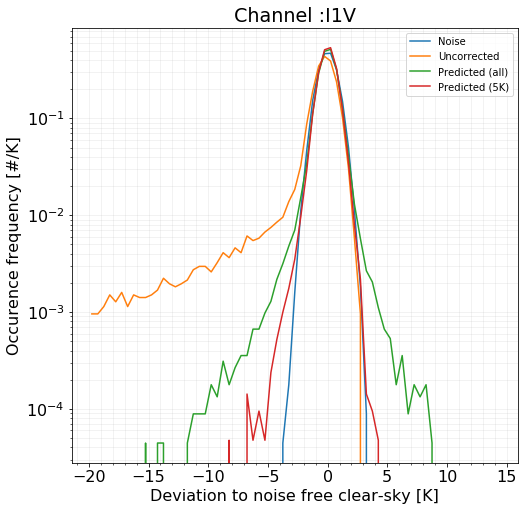

In [7]:
fig, ax = plt.subplots(1,1, figsize = [8,8])

center = (bins[:-1] + bins[1:]) / 2

ax.plot(center, hist_noise[0])
ax.plot(center, hist_prior[0])
ax.plot(center, hist_pre[0])
#ax.plot(center, hist_pos_mean[0])
ax.plot(center, hist_pos_mean_5[0])
#ax.plot(center, hist_pos_mean_10[0])
#ax.plot(center, hist_pos_mean_15[0])

ax.set_yscale('log')
ax.set_ylabel('Occurence frequency [#/K]')
ax.set_xlabel('Deviation to noise free clear-sky [K]')
ax.xaxis.set_minor_locator(MultipleLocator(1))
#ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which = 'both', alpha = 0.2)


ax.legend(["Noise", "Uncorrected", "Predicted (all)", "Predicted (5K)", "Predicted(15K)" ], prop={'size': 10})

ax.set_title("Channel :%s"%target)

fig.savefig('Figures/ICI_%s'%str(target))


In [8]:
im = np.abs(y_pos_mean - y_prior[:, i183]) <= 5.0
statistics.calculate_statistics_T(y_prior, y0, y, y_pre[:, 3], im, i183)

\begin{tabular}{lrrrr}
\hline
          &   noise &   uncorrected &   corrected\_all &   corrected\_filtered \\
\hline
 bias     &    0.00 &         -1.90 &            0.01 &                 0.02 \\
 mae      &    0.64 &          2.34 &            0.65 &                 0.58 \\
 std      &    0.80 &          8.92 &            0.96 &                 0.75 \\
 skewness &    0.01 &         -8.00 &           -0.54 &                -0.36 \\
 rejected &    0.00 &          0.00 &            0.00 &                 6.41 \\
\hline
\end{tabular}


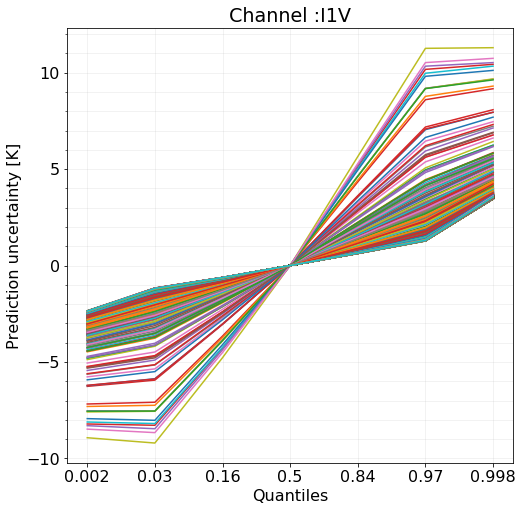

In [9]:
statistics.uncertainty(y_pre, target, 'uncertainty')

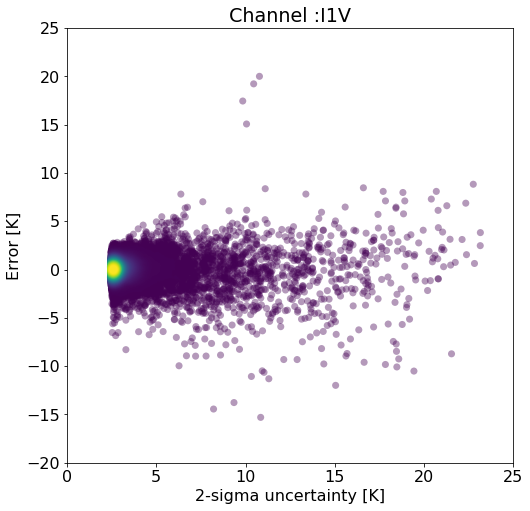

In [10]:
statistics.scatter_error_uncertainty(y_pre, y0, target, 'scatter_uncertainty')



33154


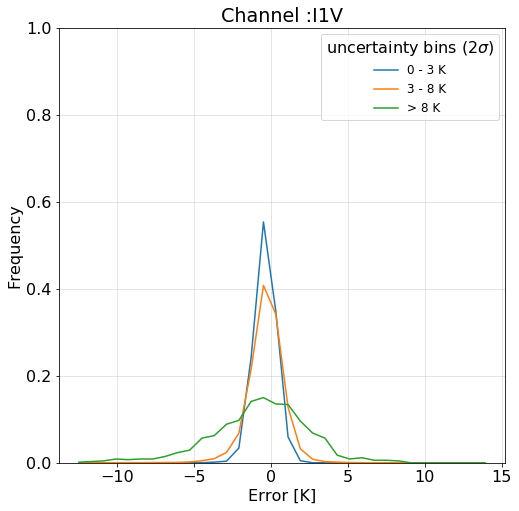

In [11]:
dtb =(y_pre[:, 3] - y0)
uncertain = y_pre[:, 5] - y_pre[:, 1]
ulim = [3, 8] #I1V
#ulim = [3, 4] #I2V
#ulim = [1, 1.5 ]#I3V

im = uncertain < ulim[0]
print (np.sum(im))
bins = np.arange(-12.5, 15., 0.8)
hist = np.histogram(dtb[im], bins, density = True)
fig, ax = plt.subplots(1, 1, figsize = [8,8])
ax.plot(bins[:-1], hist[0])


im = np.logical_and((uncertain < ulim[1]), ( uncertain >= ulim[0]) )
hist = np.histogram(dtb[im], bins, density = True)

ax.plot(bins[:-1], hist[0])

im = uncertain >=ulim[1]
hist = np.histogram(dtb[im], bins, density = True)

ax.plot(bins[:-1], hist[0])
ax.set_ylabel('Frequency')
ax.set_xlabel('Error [K]')
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.grid(which = 'both', alpha = 0.4)

ax.set_ylim(0, 1)

ax.legend([  '0 - ' + str(ulim[0]) + ' K',
            str(ulim[0]) +' - ' + str(ulim[1]) + ' K',
             '> ' + str(ulim[1]) + ' K' ], title = "uncertainty bins (2$\sigma$)", prop={'size': 12})

ax.set_title("Channel :%s"%target)

fig.savefig('Figures/Frequency_uncertainty_bins_%s'%str(target))

In [12]:
### calibration plots

Text(0, 0.5, 'Observed frequency')

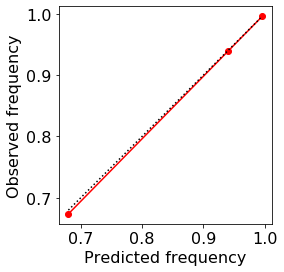

In [13]:
from torch.utils.data import DataLoader, random_split
n = len(data)
n_train = int(0.01 * n)
n_val = n - n_train
training_data, validation_data = random_split(data, [n_train, n_val])
x, y = qrnn.calibration(validation_data)
f, ax = plt.subplots(1, 1)
ax.plot(x, y, marker = "o", c = 'r')
ax.plot(x, x, ls = ":", c = "k")
#ax.set_xlim([0.1, 0.9])
#ax.set_ylim([0.1, 0.9])
ax.set_aspect(1.0)
ax.set_xlabel("Predicted frequency")
ax.set_ylabel("Observed frequency")

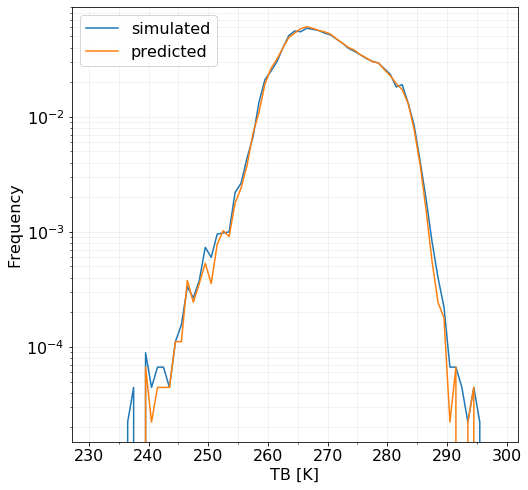

In [14]:
bins = np.arange(230, 300, 1)
h0 = np.histogram(y0, bins, density = True)
h_p = np.histogram(y_pre[:, iq], bins, density = True)
center = (bins[:-1] + bins[1:])/2
fig, ax = plt.subplots(1,1, figsize = [8,8])
ax.plot(center, h0[0])
ax.plot(center, h_p[0])
ax.set_yscale('log')
ax.set_ylabel('Frequency')
ax.set_xlabel('TB [K]')
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.grid(which = 'both', alpha = 0.2)
ax.legend(["simulated", "predicted"])
fig.savefig('Figures/PDF_%s'%target)

In [15]:
y_pre_all = y_pre[:,:]

## Load QRNN using only single 183 GHz channel

In [16]:
inChannels = np.array([target, 'I5V' , 'I6V', 'I7V', 'I8V', 'I9V', 'I10V', 'I11V'])
i183, = np.argwhere(inChannels == target)[0]

data = iciData("TB_ICI_test.nc", 
               inChannels, target, 
               batch_size = batchSize)  

x_noise = data.add_noise(data.x, data.index)




In [17]:
file = 'qrnn_ici_%s_%s_%s_single.nc'%(depth, width, target)
print (file)
qrnn = QRNN.load(file)
y_pre, y_prior, y0, y, y_pos_mean = statistics.predict(data, qrnn)


binstep = 0.5
bins = np.arange(-20, 15, binstep)
iq = np.argwhere(quantiles == 0.5)[0,0]

hist_noise  = statistics.calculate_pdf(y, y0, bins)

hist_pre    = statistics.calculate_pdf(y_pre[:, iq], y0, bins)

hist_prior  = statistics.calculate_pdf(y_prior[:, i183], y0, bins)

hist_pos_mean    = statistics.calculate_pdf(y_pre[:, iq], y0, bins)

im = np.abs(y_pos_mean - y_prior[:, i183]) <= 5.0
hist_pos_mean_5  = statistics.calculate_pdf(y_pos_mean, y0, bins, im)

im = np.abs(y_pos_mean - y_prior[:, i183]) <= 10.0
hist_pos_mean_10 = statistics.calculate_pdf(y_pos_mean, y0, bins, im)

im = np.abs(y_pos_mean - y_prior[:, i183]) <= 15.0
hist_pos_mean_15 = statistics.calculate_pdf(y_pos_mean, y0, bins, im)





qrnn_ici_4_128_I1V_single.nc
[0, 5, 6, 7, 8, 9, 10, 11]


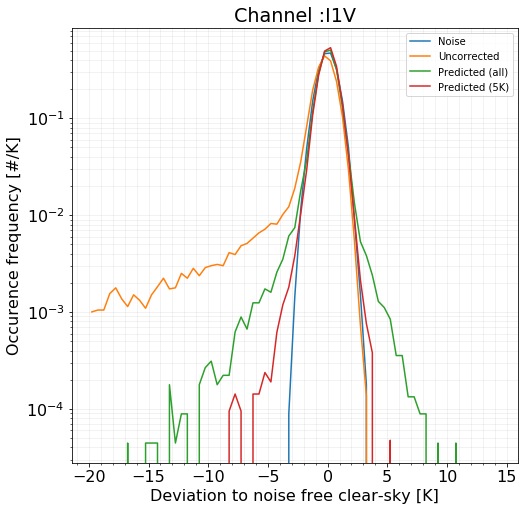

In [18]:
fig, ax = plt.subplots(1,1, figsize = [8,8])
center = (bins[:-1] + bins[1:]) / 2
ax.plot(center, hist_noise[0])
ax.plot(center, hist_prior[0])
ax.plot(center, hist_pre[0])
#ax.plot(center, hist_pos_mean[0])
ax.plot(center, hist_pos_mean_5[0])
#ax.plot(center, hist_pos_mean_10[0])
#ax.plot(center, hist_pos_mean_15[0])

ax.set_yscale('log')
ax.set_ylabel('Occurence frequency [#/K]')
ax.set_xlabel('Deviation to noise free clear-sky [K]')
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which = 'both', alpha = 0.2)


ax.legend(["Noise", "Uncorrected", "Predicted (all)", "Predicted (5K)", "Predicted(15K)" ], prop={'size': 10})

ax.set_title("Channel :%s"%target)

fig.savefig('Figures/ICI_%s_single'%str(target))


In [19]:
im = np.abs(y_pos_mean - y_prior[:, i183]) <= 5.0
statistics.calculate_statistics_T(y_prior, y0, y, y_pre[:, 3], im, i183)



\begin{tabular}{lrrrr}
\hline
          &   noise &   uncorrected &   corrected\_all &   corrected\_filtered \\
\hline
 bias     &   -0.00 &         -1.90 &           -0.01 &                 0.01 \\
 mae      &    0.64 &          2.34 &            0.69 &                 0.59 \\
 std      &    0.80 &          8.93 &            1.05 &                 0.78 \\
 skewness &   -0.02 &         -7.99 &           -1.21 &                -0.50 \\
 rejected &    0.00 &          0.00 &            0.00 &                 6.40 \\
\hline
\end{tabular}


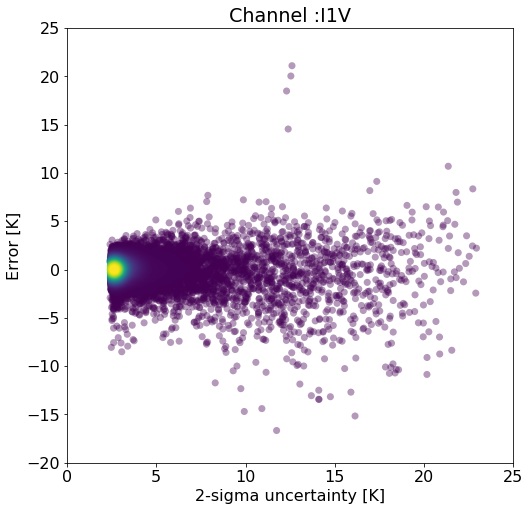

In [20]:
statistics.scatter_error_uncertainty(y_pre, y0, target, 'scatter_uncertainty_single')

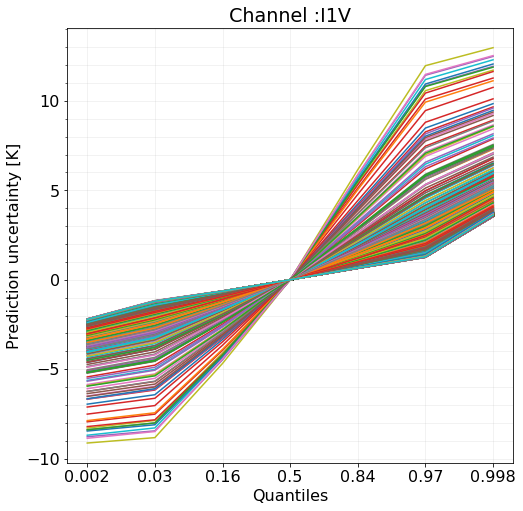

In [21]:
statistics.uncertainty(y_pre, target, 'uncertainty_single')


32506


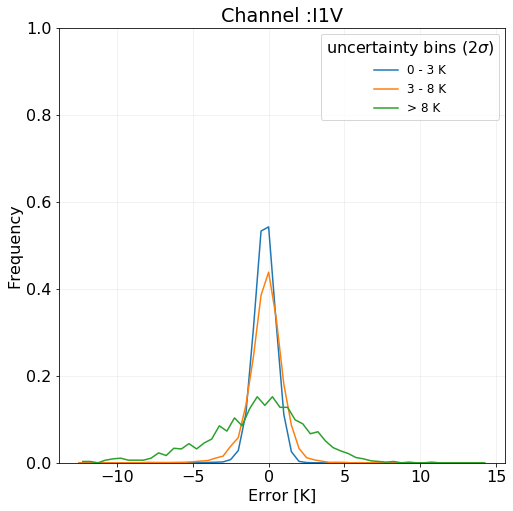

In [22]:
dtb =(y_pre[:, 3] - y0)
uncertainty = y_pre[:, 5] - y_pre[:, 1]
ulim = [3, 8] #I1V
#ulim = [3, 4] #I2V
#ulim = [1, 1.5 ]#I3V

im = uncertainty < ulim[0]
print (np.sum(im))
bins = np.arange(-12.5, 15., 0.5)
hist = np.histogram(dtb[im], bins, density = True)
fig, ax = plt.subplots(1, 1, figsize = [8,8])
ax.plot(bins[:-1], hist[0])


im = np.logical_and((uncertainty < ulim[1]), ( uncertainty >= ulim[0]) )
hist = np.histogram(dtb[im], bins, density = True)

ax.plot(bins[:-1], hist[0])

im = uncertainty >=ulim[1]
hist = np.histogram(dtb[im], bins, density = True)

center = (bins[:-1] + bins[1:])/2
ax.plot(center, hist[0])
ax.set_ylabel('Frequency')
ax.set_xlabel('Error [K]')
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.grid(which = 'both', alpha = 0.2)

ax.set_ylim(0, 1)

ax.legend([  '0 - ' + str(ulim[0]) + ' K',
            str(ulim[0]) +' - ' + str(ulim[1]) + ' K',
             '> ' + str(ulim[1]) + ' K' ], title = "uncertainty bins (2$\sigma$)", prop={'size': 12})

ax.set_title("Channel :%s"%target)

fig.savefig('Figures/Frequency_uncertainty_bins_%s_single'%str(target))

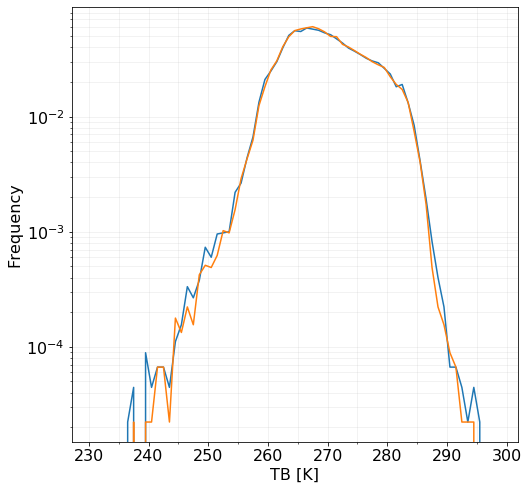

In [23]:
bins = np.arange(230, 300, 1)
h0 = np.histogram(y0, bins, density = True)
h_p = np.histogram(y_pre[:, iq], bins, density = True)
center = (bins[:-1] + bins[1:])/2
fig, ax = plt.subplots(1,1, figsize = [8,8])
ax.plot(center, h0[0])
ax.plot(center, h_p[0])
ax.set_yscale('log')
ax.set_ylabel('Frequency')
ax.set_xlabel('TB [K]')
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.grid(which = 'both', alpha = 0.2)
fig.savefig('Figures/PDF_%s_single'%target)

/home/inderpreet/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


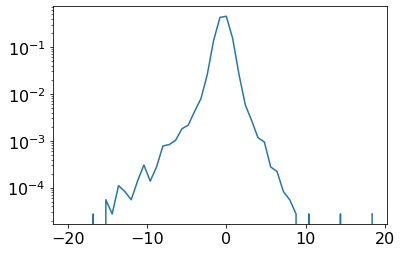

In [24]:
fig, ax = plt.subplots(1, 1)
bins = np.arange(-20, 20, 0.8)
hist = np.histogram(dtb[data.surface>0], bins, density = True)
ax.plot(bins[:-1], hist[0] )

hist = np.histogram(dtb[data.surface<1], bins, density = True)
ax.plot(bins[:-1], hist[0] )
ax.set_yscale('log')

In [25]:
from torch.utils.data import DataLoader, random_split
n = len(data)
n_train = int(0.01 * n)
n_val = n - n_train
training_data, validation_data = random_split(data, [n_train, n_val])

Text(0, 0.5, 'Observed frequency')

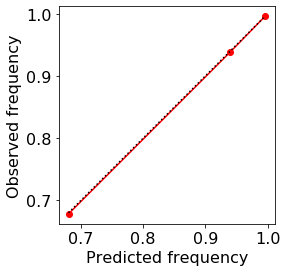

In [26]:
x, y = qrnn.calibration(validation_data)
f, ax = plt.subplots(1, 1)
ax.plot(x, y, marker = "o", c = 'r')
ax.plot(x, x, ls = ":", c = "k")
#ax.set_xlim([0.1, 0.9])
#ax.set_ylim([0.1, 0.9])
ax.set_aspect(1.0)
ax.set_xlabel("Predicted frequency")
ax.set_ylabel("Observed frequency")

In [27]:
dtb = y_pre[:, iq] - y0


In [28]:
dBZ = np.load('dbz_test.npy', allow_pickle = True)

In [29]:
#fig, ax = plt.subplots(1,1, figsize = [8,8])
A = []
corr = []
for i in range(45000):
    dbz = np.asarray(dBZ[i])
    dbz = dbz[dbz > -20]
    n = dbz.size
    if n > 0:
        d = np.repeat(dtb[i], n)

        corr.append(np.corrcoef(d, dbz)[1, 0])
#        ax.scatter(d, dbz, color = 'b')
    else:
        A.append(dtb)

/home/inderpreet/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/inderpreet/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/inderpreet/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/inderpreet/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/inderpreet/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [30]:
dbz

array([], dtype=float64)

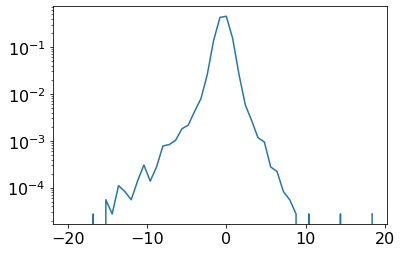

In [31]:
fig, ax = plt.subplots(1,1)
hist = np.histogram(np.array(A), bins, density = True)
ax.plot(bins[:-1], hist[0])
ax.set_yscale('log')

In [32]:
i183

0

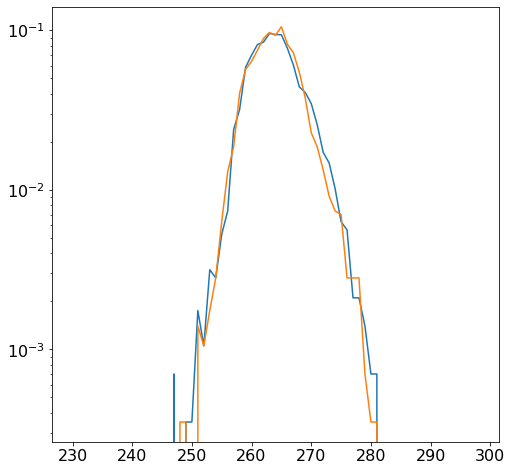

In [33]:
im = np.abs(y_pre[:, iq] - y_prior[:, i183]) > 5.0 
d = y_pre_all[:, iq] - y_pre[:, iq]

bins = np.arange(230, 300, 1)

hist = np.histogram( y_pre_all[im, iq]  , bins, density = True)

fig, ax = plt.subplots(1, 1, figsize = [8, 8])

ax.plot(bins[:-1], hist[0])
ax.set_yscale('log')

hist = np.histogram( y_pre[im, iq] , bins, density = True)
ax.plot(bins[:-1], hist[0])

ax.set_yscale('log')

(240, 300)

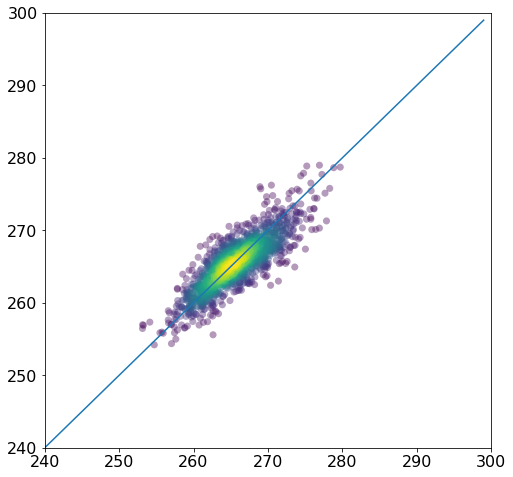

In [34]:
from statistics import density
fig, ax = plt.subplots(1,1, figsize = [8, 8])
im = np.abs(y_pre[:, iq] - y_prior[:, i183]) > 15.0 

x, y, z = density(y_pre_all[im, iq], y_pre[im, iq])
ax.scatter(x, y, c=z, s=50, edgecolor='', alpha = 0.4)

xx = np.arange(230, 300, 1)
yy = xx
ax.plot(xx, yy)
ax.set_xlim(240, 300)
ax.set_ylim(240, 300)

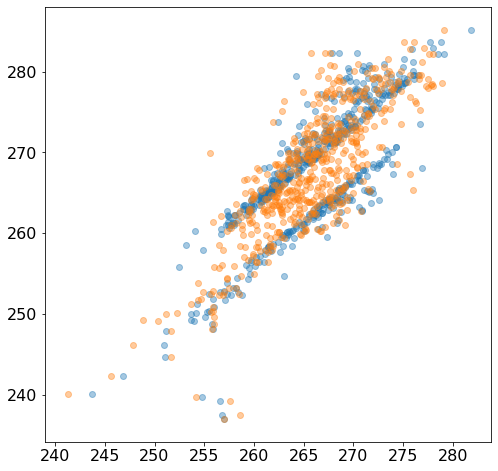

In [35]:
im = np.abs(y_pre_all[:, iq] - y0) > 3.0 
fig, ax = plt.subplots(1, 1, figsize = [8,8])



ax.scatter(y_pre_all[im, iq] , y0[im], alpha = 0.4)
ax.scatter(y_pre[im, iq] , y0[im] , alpha = 0.4 )

#ax.scatter(y_pre_all[im, 5] - y_pre_all[im, 3], y_pre[im, 5] - y_pre[im, 3]  )
xx = np.arange(100, 300)
yy = xx
#ax.plot(xx, yy, 'r')